## Import module

### Install preprocessor

In [ ]:
!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import area

In [ ]:
import os
import math
import random
import torch

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
from collections import Counter
from tqdm import tqdm

from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity

from sklearn.model_selection import train_test_split
from facenet_pytorch import MTCNN

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.io import read_image
from torchvision import models


from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Prepare dataset


### Load data

In [ ]:
dataset_path = './gdrive/MyDrive/資安/Celebrity Faces Dataset'

In [ ]:
#class_names = os.listdir(dataset_path)
class_names = ['Angelina Jolie', 'Hugh Jackman', 'Leonardo DiCaprio', 'Denzel Washington', 'Megan Fox', 'Natalie Portman', 'Brad Pitt', 'Kate Winslet', 'Jennifer Lawrence', 'Johnny Depp', 'Tom Hanks', 'Sandra Bullock', 'Robert Downey Jr', 'Nicole Kidman', 'Scarlett Johansson', 'Will Smith', 'Tom Cruise']
print(class_names)

['Angelina Jolie', 'Hugh Jackman', 'Leonardo DiCaprio', 'Denzel Washington', 'Megan Fox', 'Natalie Portman', 'Brad Pitt', 'Kate Winslet', 'Jennifer Lawrence', 'Johnny Depp', 'Tom Hanks', 'Sandra Bullock', 'Robert Downey Jr', 'Nicole Kidman', 'Scarlett Johansson', 'Will Smith', 'Tom Cruise']


In [ ]:
image_path_list = []
image_list = []
label_list = []

In [ ]:
temp_count = 0
for idx, class_name in enumerate(class_names):
  imgs = os.listdir(os.path.join(dataset_path, class_name))
  for i, img in enumerate(imgs):
    path = os.path.join(dataset_path, class_name, img)
    image_path_list.append(path)
    image_list.append(temp_count)
    label_list.append(idx)
    temp_count += 1

In [ ]:
print(image_path_list)
print(image_list)
print(label_list)

['./gdrive/MyDrive/資安/Celebrity Faces Dataset/Angelina Jolie/002_8f8da10e.jpg', './gdrive/MyDrive/資安/Celebrity Faces Dataset/Angelina Jolie/010_f99d79e3.jpg', './gdrive/MyDrive/資安/Celebrity Faces Dataset/Angelina Jolie/006_9135205d.jpg', './gdrive/MyDrive/資安/Celebrity Faces Dataset/Angelina Jolie/009_fb3e6174.jpg', './gdrive/MyDrive/資安/Celebrity Faces Dataset/Angelina Jolie/004_f61e7d0c.jpg', './gdrive/MyDrive/資安/Celebrity Faces Dataset/Angelina Jolie/008_d1f87068.jpg', './gdrive/MyDrive/資安/Celebrity Faces Dataset/Angelina Jolie/012_cfcd4007.jpg', './gdrive/MyDrive/資安/Celebrity Faces Dataset/Angelina Jolie/005_582c121a.jpg', './gdrive/MyDrive/資安/Celebrity Faces Dataset/Angelina Jolie/001_fe3347c0.jpg', './gdrive/MyDrive/資安/Celebrity Faces Dataset/Angelina Jolie/013_95ecbd39.jpg', './gdrive/MyDrive/資安/Celebrity Faces Dataset/Angelina Jolie/007_cabbfcbb.jpg', './gdrive/MyDrive/資安/Celebrity Faces Dataset/Angelina Jolie/003_57612506.jpg', './gdrive/MyDrive/資安/Celebrity Faces Dataset/Angeli

### Train/Valid/Test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.1, random_state=1, stratify=label_list)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1, stratify=y_train)

In [ ]:
print("Train length:", len(X_train))
print("Test length:", len(X_test))
print("Valid length:", len(X_val))

Train length: 1375
Test length: 170
Valid length: 153


In [ ]:
Counter(y_train)

Counter({15: 81,
         16: 81,
         11: 81,
         0: 81,
         4: 81,
         6: 81,
         8: 81,
         14: 81,
         1: 81,
         9: 81,
         12: 81,
         10: 80,
         7: 80,
         13: 81,
         3: 81,
         2: 81,
         5: 81})

In [ ]:
Counter(y_test)

Counter({4: 10,
         1: 10,
         0: 10,
         10: 10,
         16: 10,
         3: 10,
         14: 10,
         13: 10,
         11: 10,
         5: 10,
         12: 10,
         8: 10,
         2: 10,
         9: 10,
         6: 10,
         7: 10,
         15: 10})

In [ ]:
Counter(y_val)

Counter({4: 9,
         0: 9,
         7: 9,
         14: 9,
         15: 9,
         1: 9,
         2: 9,
         10: 9,
         13: 9,
         5: 9,
         16: 9,
         11: 9,
         12: 9,
         8: 9,
         6: 9,
         3: 9,
         9: 9})

### Make dataset

In [ ]:
class myDataset(Dataset):
    def __init__(self, img_idxs, img_labels, transform=None, target_transform=None):
        self.img_labels = img_labels
        self.img_idxs = img_idxs
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image_idx = self.img_idxs[idx]
        image = read_image(image_path_list[image_idx])
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
dataset = myDataset(X_train, y_train)
print(len(dataset))

1375


### Have a glance

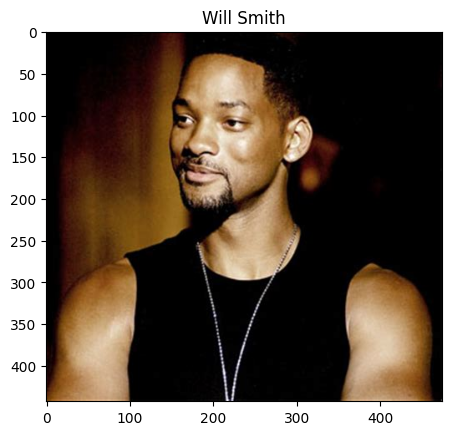

In [ ]:
show_img, show_lbl = dataset[0]

plt.imshow(show_img.permute(1, 2, 0))
plt.title(class_names[show_lbl])
plt.show()

## Preprocess

### Model

In [ ]:
mtcnn = MTCNN()

### Definition

#### Crop face

In [ ]:
class CropFace:
  def __init__(self):
    self.mtcnn = MTCNN()

  def __call__(self, img):
    img_cropped = self.mtcnn(img)
    img_cropped = np.transpose(img_cropped, (1, 2, 0)).numpy()
    img_result_arr = (img_cropped / 2 + 0.5)  * 255 #[-1, 1] -> [0, 1]
    img_result_arr = img_result_arr.astype(np.uint8)
    img_result = Image.fromarray(img_result_arr)
    return img_result

In [ ]:
crop_test = transforms.Compose([
    transforms.ToPILImage(),
    CropFace()
])

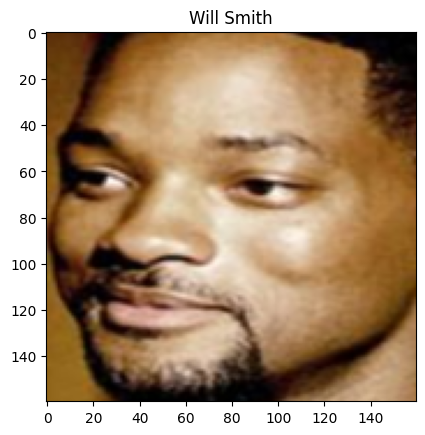

In [ ]:
img_cropped = crop_test(show_img)
plt.imshow(img_cropped)
plt.title(class_names[show_lbl])
plt.show()

#### Blur


In [ ]:
class Blurring:
  def __init__(self, factor=3.0):
    self.factor = factor

  def __call__(self, img: Image) -> Image:
    if self.factor == 0:
      return img
    img = np.array(img)
    img = cv2.GaussianBlur(img, (self.factor, self.factor), 0)
    img = Image.fromarray(img)
    return img

#### Pixelize

In [ ]:
class Pixelization:
  def __init__(self, blocks=3):
    self.blocks = blocks

  def __call__(self, img: Image) -> Image:
    if self.blocks == 0:
      return img
    # divide the input image into NxN blocks
    img = np.array(img)
    (h, w) = img.shape[:2]


    img = cv2.resize(img, (int(h/self.blocks), int(w/self.blocks)), interpolation=cv2.INTER_LINEAR)
    img = cv2.resize(img, (h, w), interpolation=cv2.INTER_NEAREST)

    img = Image.fromarray(img)
    return img


#### Diffential Privacy

#### Regular

In [ ]:
tform = transforms.Compose([
    transforms.ToPILImage(),
    CropFace(),
    transforms.Resize([224,224]),
    transforms.ToTensor()
])

### Transform for model

In [ ]:
tform = transforms.Compose([
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
    transforms.ToPILImage(),
    CropFace(),
    #transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(224),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


tform_argument = []
tform_argument.append(tform)

blurring_param = [0, 0, 0, 0, 15, 45, 99] #0 -> nothing
pixelization_param = [2, 4, 8, 16, 0, 0, 0] #0 -> nothing

for p1, p2 in zip(blurring_param, pixelization_param):
  de_id = transforms.Compose([
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
    transforms.ToPILImage(),
    CropFace(),
    Blurring(p1),
    Pixelization(p2),
    #transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(224),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])
  tform_argument.append(de_id)

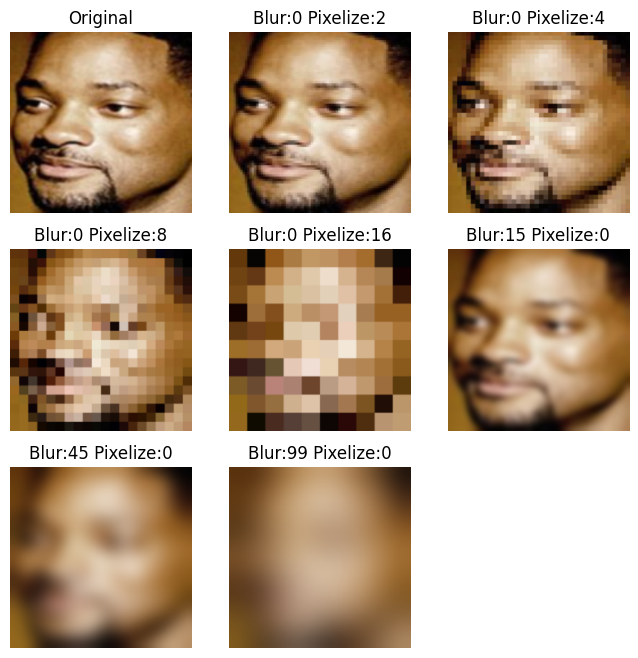

In [ ]:
w = 10
h = 10

columns = 3
rows = 3

fig = plt.figure(figsize=(8, 8))
ax = []

for i in range(1, columns*rows +1):
  if i > len(tform_argument):
    break
  test = tform_argument[i - 1](show_img)
  test = np.transpose(test, (1, 2, 0)).numpy()
  ax.append(fig.add_subplot(rows, columns, i))
  if i == 1:
    ax[-1].set_title(f"Original")
  else:
    ax[-1].set_title(f"Blur:{blurring_param[i - 2]} Pixelize:{pixelization_param[i - 2]}")  # set title
  plt.axis('off')
  plt.imshow(test)
plt.show()

### Difference Indicator

<ipython-input-61-f5ecde9f0665>:23: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  s1 = structural_similarity(img_origin, img_blur, multichannel= True)
<ipython-input-61-f5ecde9f0665>:24: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  s2 = structural_similarity(img_origin, img_pixelation, multichannel= True)


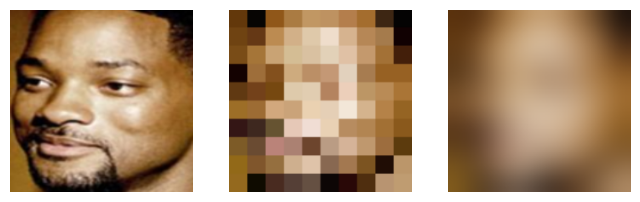

MSE_blur: 0.021, PSNR_blur: 64.952, SSIM_blur: 0.645, MSE_pixelation: 0.020, PSNR_pixelation: 65.103 SSIM_pixelation: 0.585


In [ ]:
def PSNR(MSE):
  PSNR = 10 * np.log10((255 * 255) / MSE)
  return PSNR

adjustedImage = tform_argument[0](show_img)
adjustedImage = np.transpose(adjustedImage, (1, 2, 0)).numpy()
img_origin = adjustedImage

p_idx = 4 #1-4 -> 2, 4, 8, 16
pixlizedImage = tform_argument[p_idx](show_img)
pixlizedImage = np.transpose(pixlizedImage, (1, 2, 0)).numpy()
img_pixelation = pixlizedImage

b_idx = 7 #5-7 -> 15, 45, 99
blurredImage = tform_argument[b_idx](show_img)
blurredImage = np.transpose(blurredImage, (1, 2, 0)).numpy()
img_blur = blurredImage

m1 = mean_squared_error(img_origin, img_blur)
m2 = mean_squared_error(img_origin, img_pixelation)
p1 = PSNR(m1)
p2 = PSNR(m2)
s1 = structural_similarity(img_origin, img_blur, multichannel= True)
s2 = structural_similarity(img_origin, img_pixelation, multichannel= True)

w = 10
h = 10

columns = 3
rows = 1

fig = plt.figure(figsize=(8, 8))
ax = []
show_list = [img_origin, img_pixelation, img_blur]

for i in range(1, columns*rows +1):
  if i > len(tform_argument):
    break
  test = show_list[i - 1]
  ax.append(fig.add_subplot(rows, columns, i))
  plt.axis('off')
  plt.imshow(test)
plt.show()



print('MSE_blur: {:.3f}, PSNR_blur: {:.3f}, SSIM_blur: {:.3f}, MSE_pixelation: {:.3f}, PSNR_pixelation: {:.3f} SSIM_pixelation: {:.3f}'.format(m1, p1, s1, m2, p2, s2))

## Model Architecture

## Attack

### Config

In [ ]:
class Config:
  epoch = 30
  batch_size = 64
  num_workers = 0
  lr = [1e-6, 1e-4, 1e-2]
  lr_step = 30
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  patience = 3
  checkpoints = "./gdrive/MyDrive/資安/atk checkpoints"
  test_model = ""

### Train

#### Model

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(512, len(class_names), bias=True)
)

model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#Param1 -> bottom few layers 10^-6
#Param2 -> others 10^-4
#Param3 -> addition layer 10^-2
modelParams = []
temps = []

#print("Param1:")
for param in list(model.parameters())[0:3]:
  temps.append(param)
  #print(param.shape)

modelParams.append(temps)

temps = []
#print("Param2:")
for param in list(model.parameters())[3:-2]:
  temps.append(param)
  #print(param.shape)

modelParams.append(temps)

temps = []
#print("Param3:")
for param in list(model.parameters())[-2:]:
  temps.append(param)
  #print(param.shape)

modelParams.append(temps)


#### Data loader

In [ ]:
all_train_ds_list = []

for tfrom_arg in tform_argument:
  temp = myDataset(X_train, y_train, tfrom_arg)
  all_train_ds_list.append(temp)

train_ds = ConcatDataset(all_train_ds_list)

print(len(train_ds))
train_dataLoader = DataLoader(train_ds, batch_size=Config.batch_size, shuffle=True,
                num_workers=Config.num_workers, drop_last=True)

11000


In [ ]:
all_valid_ds_list = []

for tfrom_arg in tform_argument[-2:]:
  temp = myDataset(X_val, y_val, tfrom_arg)
  all_valid_ds_list.append(temp)

valid_ds = ConcatDataset(all_valid_ds_list)

print(len(valid_ds))
valid_dataLoader = DataLoader(valid_ds, batch_size=Config.batch_size, shuffle=True,
                num_workers=Config.num_workers, drop_last=True)

306


#### Loss function

In [ ]:
# Training Setup

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    [
        {'params': modelParams[0], 'lr':Config.lr[0]},
        {'params': modelParams[1], 'lr':Config.lr[1]},
        {'params': modelParams[2], 'lr':Config.lr[2]},
    ],
    lr=Config.lr[1],
)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=Config.lr_step, gamma=0.1)

#### Checkpoints


In [ ]:
# Checkpoints Setup
os.makedirs(Config.checkpoints, exist_ok=True)

In [ ]:
def optimizer_to(optim, device):
    for param in optim.state.values():
        # Not sure there are any global tensors in the state dict
        if isinstance(param, torch.Tensor):
            param.data = param.data.to(device)
            if param._grad is not None:
                param._grad.data = param._grad.data.to(device)
        elif isinstance(param, dict):
            for subparam in param.values():
                if isinstance(subparam, torch.Tensor):
                    subparam.data = subparam.data.to(device)
                    if subparam._grad is not None:
                        subparam._grad.data = subparam._grad.data.to(device)

In [ ]:
need_to_train = False #Set true if you want to continue training
last_epoch = -1
try:
  weight_list = os.listdir(Config.checkpoints)
  weight_list = [w.split('.')[0] for w in weight_list]
  lastest_weight = f"{weight_list[-1]}.pth"
  best_weight_dir = os.path.join(Config.checkpoints, lastest_weight)
  checkpoint = torch.load(best_weight_dir, map_location=Config.device)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  optimizer_to(optimizer,Config.device)
  last_epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  Config.test_model = best_weight_dir
  print(f"Load best weight path:{best_weight_dir}, epoch:{last_epoch} / {Config.epoch}, loss:{loss}")
except Exception as e:
  print(e)
  need_to_train = True

Load best weight path:./gdrive/MyDrive/資安/atk checkpoints/9.pth, epoch:9 / 30, loss:0.18673479557037354


#### Training

In [ ]:
training_loss = []
validation_loss = []
train_last_epoch = 0

In [ ]:
if need_to_train:
  model.to(Config.device)
  best_loss = 100 #For valid set
  count = 0
  for e in range(last_epoch + 1, Config.epoch):
    correct_count = 0
    train_last_epoch = e
    model.train()

    with tqdm(train_dataLoader, desc=f"Epoch {e}/{Config.epoch}", total=len(train_dataLoader)) as progress_bar:
      for data, labels in progress_bar:
        data = data.to(Config.device)
        labels = labels.to(Config.device)
        optimizer.zero_grad()
        outputs = model(data)
        train_loss = criterion(outputs, labels)
        train_loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        correct_count += torch.sum(preds == labels.data)

        progress_bar.set_postfix({"loss": train_loss.item()})

    print(f"Epoch {e}/{Config.epoch}, Train loss: {train_loss}, acc: {correct_count.double() / (len(train_dataLoader) * Config.batch_size)}")
    training_loss.append(train_loss)

    correct_count = 0
    model.eval()

    with tqdm(valid_dataLoader, desc=f"Epoch {e}/{Config.epoch}", total=len(valid_dataLoader)) as progress_bar:
      for data, labels in progress_bar:
        data = data.to(Config.device)
        labels = labels.to(Config.device)
        outputs = model(data)
        val_loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        correct_count += torch.sum(preds == labels.data)

        progress_bar.set_postfix({"loss": val_loss.item()})

    print(f"Epoch {e}/{Config.epoch}, Validation loss: {val_loss}, acc: {correct_count.double() / (len(valid_dataLoader) * Config.batch_size)}")
    validation_loss.append(val_loss)

    if val_loss < best_loss:
      count = 0
      best_loss = val_loss
      # At this point also save a snapshot of the current model
      backbone_path = os.path.join(Config.checkpoints, f"{e}.pth")
      torch.save({
      'epoch': e,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': val_loss,
      }, backbone_path)
      Config.test_model = backbone_path
    else:
      count += 1
      if count >= Config.patience:
        break

    del train_loss, val_loss, outputs
    torch.cuda.empty_cache()

    scheduler.step()

In [ ]:
#Snapshot
training_loss = [1.172, 0.705, 0.271, 0.252, 0.049, 0.196, 0.068, 0.238, 0.133, 0.109, 0.115, 0.082, 0.044]
validation_loss = [1.324, 0.968, 0.82, 0.765, 0.71, 0.412, 0.236, 0.421, 0.222, 0.187, 0.395, 0.752, 0.462]
#training_loss += list(map(float, training_loss))
#validation_loss += list(map(float, validation_loss))

if train_last_epoch != 0:
  epochs = range(0, train_last_epoch + 1)

  plt.plot(epochs, training_loss, label='Training Loss')
  plt.plot(epochs, validation_loss, label='Validation Loss')

  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  plt.legend(loc='best')
  plt.show()

In [ ]:
#Snapshot
training_acc = [0.436, 0.764, 0.863, 0.903, 0.930, 0.92, 0.943, 0.954, 0.963, 0.974, 0.968, 0.970, 0.976]
validation_acc = [0.539, 0.671, 0.711, 0.727, 0.777, 0.848, 0.902, 0.867, 0.906, 0.844, 0.875, 0.851, 0.848]

if train_last_epoch != 0:
  epochs = range(0, train_last_epoch + 1)

  plt.plot(epochs, training_acc, label='Training Accuracy')
  plt.plot(epochs, validation_acc, label='Validation Accuracy')

  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  plt.legend(loc='best')
  plt.show()

### Test

#### Load model

In [ ]:
checkpoint = torch.load(Config.test_model, map_location=Config.device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
last_epoch = checkpoint['epoch']
loss = checkpoint['loss']
print(f"Load best weight path:{Config.test_model}, epoch:{last_epoch} / {Config.epoch}, loss:{loss}")

Load best weight path:./gdrive/MyDrive/資安/atk checkpoints/9.pth, epoch:9 / 30, loss:0.18673479557037354


#### Attack function

In [ ]:
# p1 = 7 # Blur
# p2 = 16 # Pixelize

p1 = 0 # Blur
p2 = 0 # Pixelize

atk_tforms = transforms.Compose([
  transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
  transforms.ToPILImage(),
  CropFace(),
  Blurring(p1),
  Pixelization(p2),
  transforms.Resize([224,224]),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

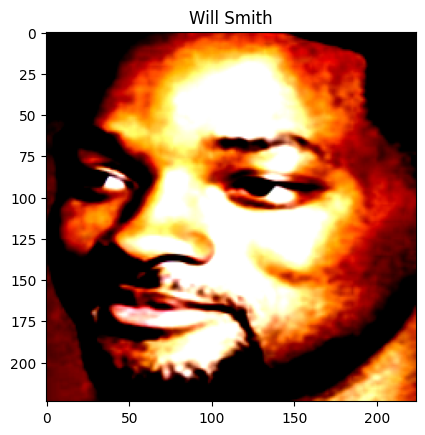

In [ ]:
show_img, show_lbl = dataset[0]

img = atk_tforms(show_img)
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[show_lbl])
plt.show()

#### Data loader

In [ ]:
test_ds = myDataset(X_test, y_test, atk_tforms, transforms.Lambda(lambda x: torch.tensor(x)))
test_dataLoader = DataLoader(test_ds, shuffle=True)

#### Testing

Top1

In [ ]:
correct_count = 0
model.eval()
model.to(Config.device)

with tqdm(test_dataLoader, total=len(test_dataLoader)) as progress_bar:
  for data, labels in progress_bar:
    data = data.to(Config.device)
    labels = labels.to(Config.device)
    outputs = model(data)
    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs, 1)
    correct_count += torch.sum(preds == labels.data)

print(f"Loss: {loss}, acc: {correct_count.double() / (len(test_dataLoader))}")

100%|██████████| 170/170 [00:56<00:00,  2.99it/s]

Loss: 0.0, acc: 1.0


Top3

In [ ]:
correct_count = 0
model.eval()
model.to(Config.device)

with tqdm(test_dataLoader, total=len(test_dataLoader)) as progress_bar:
  for data, labels in progress_bar:
    data = data.to(Config.device)
    labels = labels.to(Config.device)
    outputs = model(data)
    loss = criterion(outputs, labels)

    _, preds = torch.topk(outputs, 3)
    correct_count += torch.sum(preds == labels)

print(f"Loss: {loss}, acc: {correct_count.double() / (len(test_dataLoader))}")

#### Show

tensor([[ -5.2884,  -1.1817,   0.0646,  -7.2786,  -6.7574,  -5.8904,  -1.3162,
         -10.6230,  -0.4912,  -7.7828,  22.2753, -16.7735,  -5.5836,   7.2502,
          -4.5584,  -3.7746, -10.4603]])


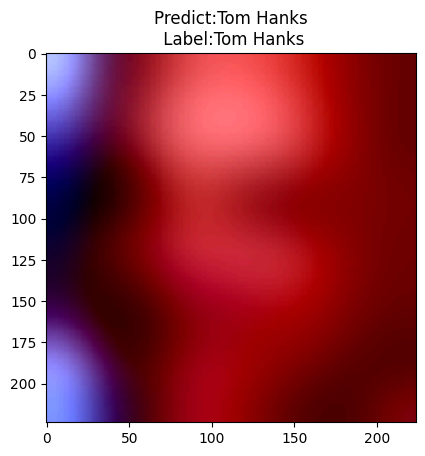

In [ ]:
idx = random.randint(0, len(test_ds)-1)
show_img, show_lbl = test_ds[idx]
show_img, show_lbl = show_img.to(Config.device), show_lbl.to(Config.device)

x = show_img
x = x.unsqueeze(0)

model.eval()
model = model.to(Config.device)

with torch.no_grad():
    out = model(x)

print(out)

show_img, show_lbl, out = show_img.cpu(), show_lbl.cpu(), out.cpu()

plt.imshow(show_img.permute(1, 2, 0))
plt.title(f"Predict:{class_names[np.argmax(out)]}\n Label:{class_names[show_lbl]}")
plt.show()

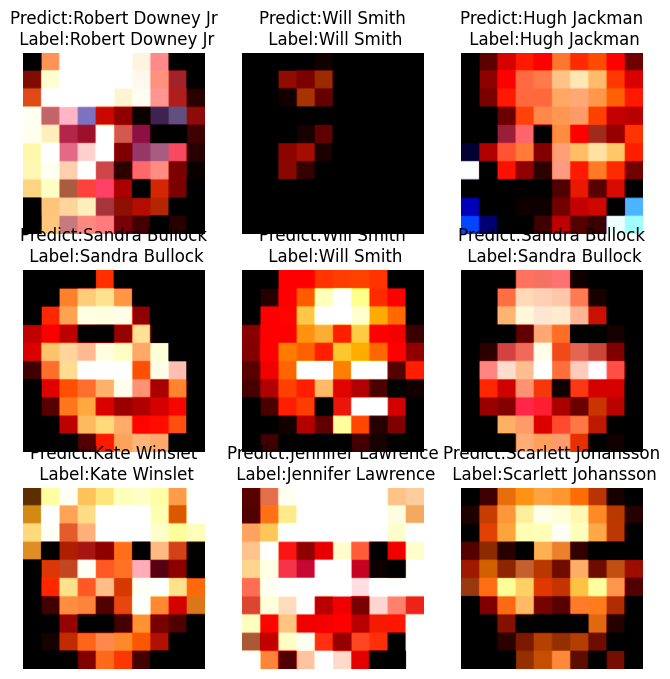

In [ ]:
w = 40
h = 40

columns = 3
rows = 3

fig = plt.figure(figsize=(8, 8))
ax = []

for i in range(1, columns*rows +1):
  idx = random.randint(0, len(test_ds)-1)
  show_img, show_lbl = test_ds[idx]
  show_img, show_lbl = show_img.to(Config.device), show_lbl.to(Config.device)

  x = show_img
  x = x.unsqueeze(0)

  model.eval()
  model = model.to(Config.device)

  with torch.no_grad():
      out = model(x)

  show_img, show_lbl, out = show_img.cpu(), show_lbl.cpu(), out.cpu()
  ax.append(fig.add_subplot(rows, columns, i))
  plt.axis('off')
  plt.imshow(show_img.permute(1, 2, 0))
  plt.title(f"Predict:{class_names[np.argmax(out)]}\n Label:{class_names[show_lbl]}")
plt.show()

## Diffential Privacy


### Train

### Test

## Tool box

When transforms output axes don't match array

In [ ]:
"""
for idx, ds in enumerate(test_ds):
  try:
    image, _ = ds
    x = tform(image)
    if not torch.equal(torch.Tensor([3, 224, 224]), torch.Tensor(list(x.shape))):
      print(x.shape, image)
  except:
    print(idx, idx)
"""

In [ ]:
"""
test_ds = myDataset(test_image_list, test_label_list)
for idx, ds in enumerate(test_ds):
  try:
    image, _ = ds
    x = tform(image)
    if not torch.equal(torch.Tensor([3, 224, 224]), torch.Tensor(list(x.shape))):
      print(x.shape, image)
  except:
    print(idx, train_image_list[idx])
"""

Check dataset

In [ ]:
"""
show_img, show_lbl = dataset[5]

plt.imshow(show_img.permute(1, 2, 0))
plt.title(class_names[show_lbl])
plt.show()
"""